# CNN-LD-TF Visualization

Script for visualization

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import os, re
import util
import cnn

import matplotlib
matplotlib.rc('font', **{'family' : 'Arial Unicode MS'})

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

Parameters

In [2]:
FLAGS = tf.app.flags.FLAGS
FLAGS.batch_size = 100
FLAGS.emb_size = 300
FLAGS.num_kernel = 100
FLAGS.min_window = 3
FLAGS.max_window = 5
FLAGS.vocab_size = 4090
FLAGS.num_classes = 65
FLAGS.sent_len = 259
FLAGS.l2_reg = 0.0
FLAGS.data_dir = os.path.join(os.getcwd(), 'data', 'ted500')
FLAGS.train_dir = os.path.join(os.getcwd(), 'model', 'ted500')

## Visualize embeddings

In [3]:
graph = tf.Graph()
with graph.as_default():
    with tf.variable_scope('cnn'):
        m = cnn.Model(FLAGS, is_train=False)
    saver = tf.train.Saver(tf.all_variables())

    with tf.Session() as sess:
        ckpt = tf.train.get_checkpoint_state(os.path.join(FLAGS.train_dir))
        saver.restore(sess, ckpt.model_checkpoint_path)

        embedding = sess.run(tf.all_variables())[0]

Get script names and unicode ranges

In [4]:
from bs4 import BeautifulSoup as bs

block = []
start = []
end = []
with open('../test/unicode_table.txt', 'r') as f:
    r = f.read()
    tables = bs(r).find_all("table")
    for t in tables:
        for row in t.find_all("tr"):
            td = row.find_all("td")
            if len(td) > 4:
                key1 = str(td[-1].get_text())
                key2 = str(td[-4].get_text())
                if len(key1) > len(key2):
                    key = key2
                else:
                    key = key1
                if key in ['None', 'Unknown']:
                    continue
                #print key
                value = str(td[-5])
                m = re.match(r".*(U\+[A-F0-9]{4})\.\.(U\+[A-F0-9]{4}).*", value)
                if m:
                    block.append(key)
                    g = m.group(1, 2)
                    start.append(unicode('\u%s' % g[0][2:] ,"unicode_escape"))
                    end.append(unicode('\u%s' % g[1][2:] ,"unicode_escape"))

Regex match

In [5]:
dic = []
for b, s, e in zip(block, start, end):
    if s < e:
        c = re.compile(ur'[%s-%s]' % (s, e))
    else:
        c = re.compile(ur'[%s-%s]' % (e, s))
    dic.append((b, c))
    
def cat(char):
    if char not in ['<unk>', '<pad>', '<ws>', '<s>', '</s>']:
        for i, k in enumerate(dic):
            if k[1].match(char):
                category = k[0]
                if category in ['Common', 'Inherited']:
                    category = 'Others'
                return category
    return 'Others'

Prepare 2-dim. embeddings data

In [6]:
from sklearn.manifold import TSNE

norm = np.sqrt(np.sum(np.square(embedding), axis=0))
normalized_embeddings = embedding / norm
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(normalized_embeddings)

vocab = util.VocabLoader(os.path.join(FLAGS.data_dir))
char = pd.DataFrame({'char': vocab.word2id.keys()}, index=vocab.word2id.values())
values = pd.DataFrame(two_d_embeddings, columns=['x', 'y'])
emb_df = pd.concat([char, values], axis=1)
emb_df['category'] = [cat(c) for c in emb_df.char]
emb_df.head()

Loaded target classes (length 65).
Loaded vocabulary (size 4090).


,char,x,y,category
0,<unk>,11.239007,-3.116807,Others
1,<pad>,19.705048,3.122865,Others
2,<ws>,18.772071,3.123901,Others
3,a,18.676330,3.076255,Basic Latin[g]
4,e,18.893577,3.003626,Basic Latin[g]


In [7]:
for name, group in emb_df.groupby(emb_df['category']):
    print(name, len(group))

('Arabic', 109)
('Arabic Presentation Forms-B', 17)
('Armenian', 44)
('Basic Latin[g]', 41)
('Bengali', 69)
('CJK Symbols and Punctuation', 9)
('Cyrillic', 43)
('Devanagari', 80)
('General Punctuation', 14)
('Georgian', 33)
('Greek and Coptic', 36)
('Gujarati', 69)
('Halfwidth and Fullwidth Forms', 21)
('Han', 1973)
('Hangul', 634)
('Hebrew', 28)
('Hiragana', 68)
('Kannada', 64)
('Katakana', 78)
('Khmer', 81)
('Latin', 83)
('Latin-1 Supplement[h]', 43)
('Malayalam', 67)
('Myanmar', 65)
('Others', 12)
('Sinhala', 66)
('Tamil', 46)
('Telugu', 59)
('Thai', 66)
('Tibetan', 72)


Plot embeddings

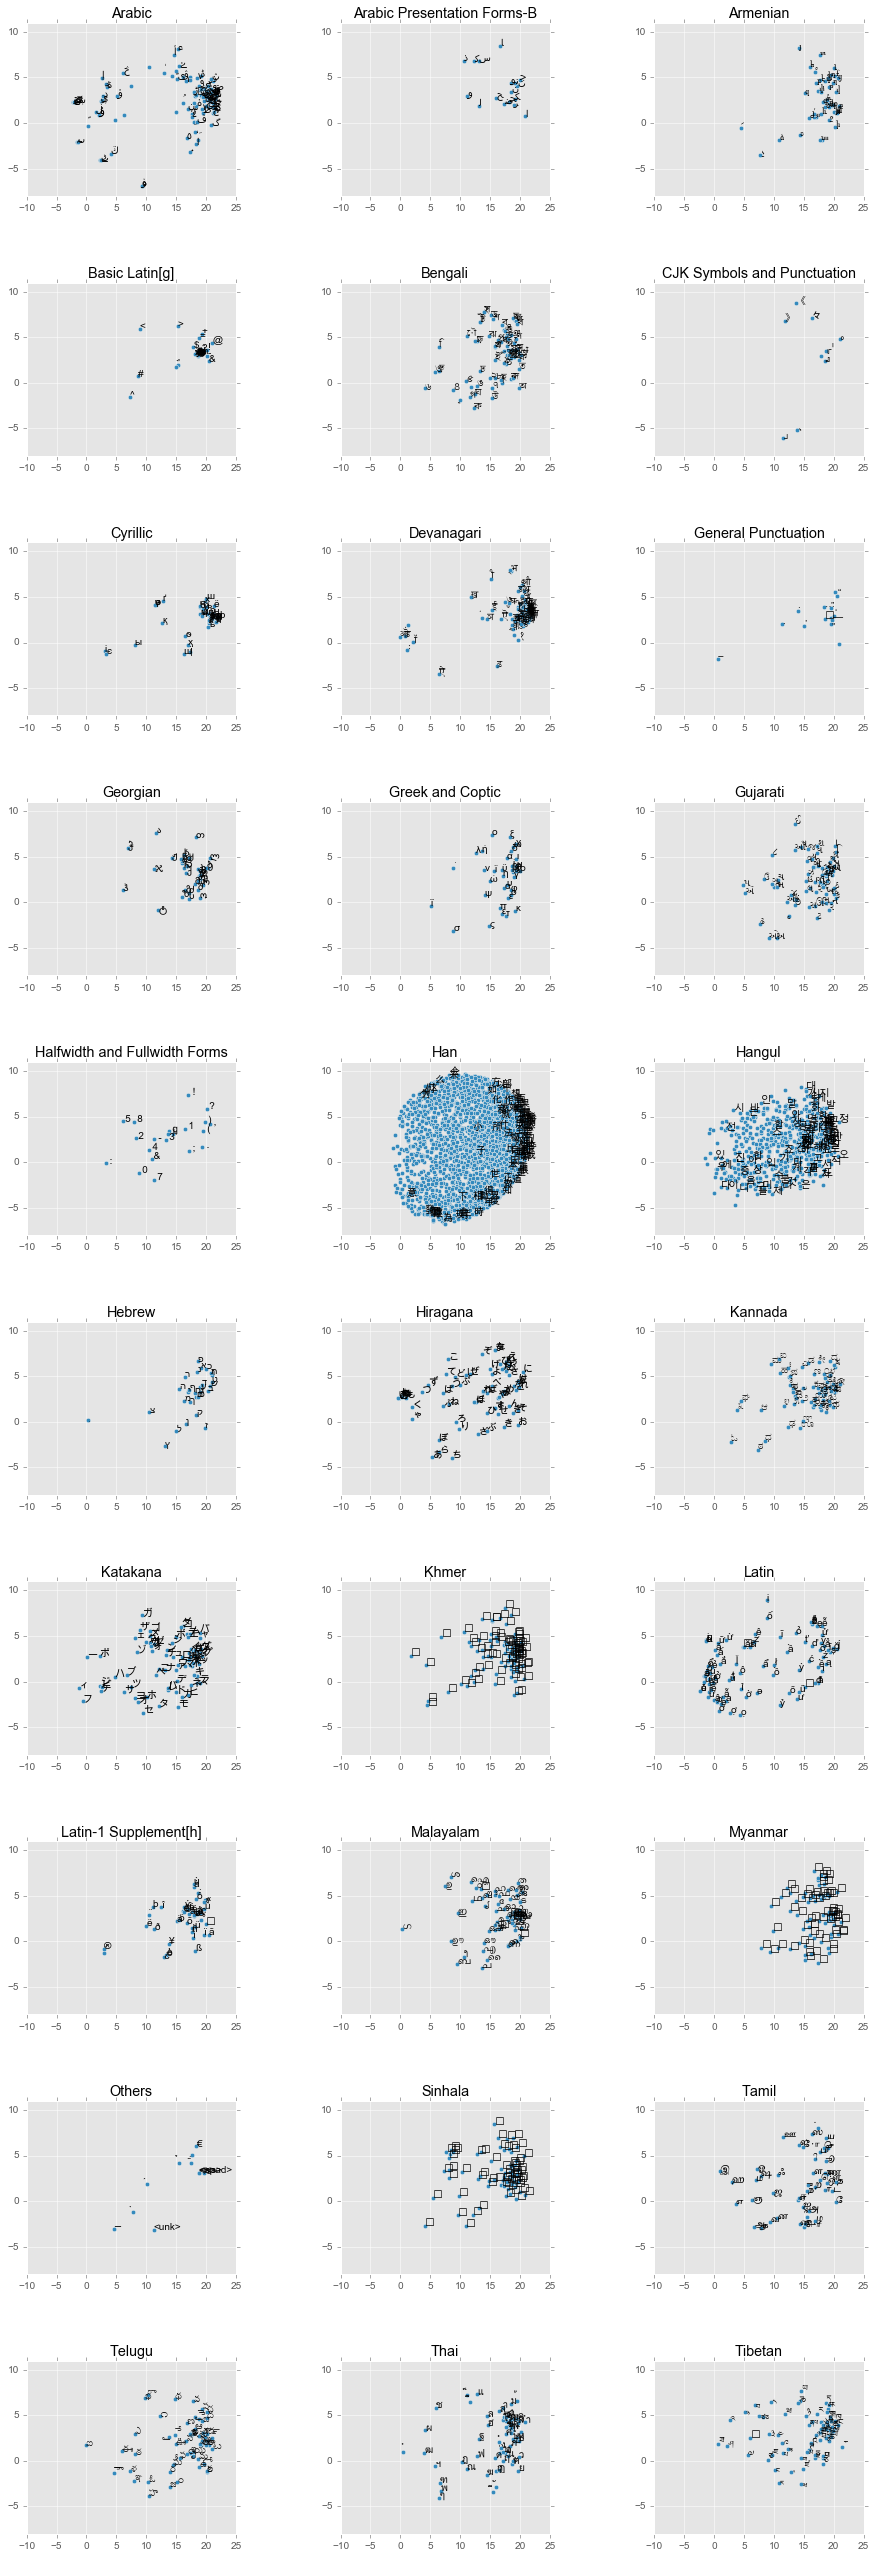

In [8]:
fig, axes = plt.subplots(10, 3, figsize=(15, 45))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i, (ax, (key, group)) in enumerate(zip(axes.flatten(), emb_df.groupby(emb_df['category']))):
    ax = group.plot(kind="scatter", x='x', y='y', ax=ax, legend=False)
    # annotate 100 labels
    for index, row in group.head(100).iterrows():
        ax.annotate(row['char'], xy=(row['x'], row['y']))
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim(-10, 25)
    ax.set_ylim(-8, 11)
    ax.set_title(key)
    
#fig.savefig('embeddings.svg')

## Evaluation

In [9]:
loader = util.DataLoader(os.path.join(FLAGS.data_dir, 'test.cPickle'), batch_size=FLAGS.batch_size)

Loaded data with 3250 examples. 100 examples per batch will be used.


In [10]:
graph = tf.Graph()
with graph.as_default():
    with tf.variable_scope('cnn'):
        m = cnn.Model(FLAGS, is_train=False)
    saver = tf.train.Saver(tf.all_variables())

    predictions = []

    with tf.Session() as sess:
        ckpt = tf.train.get_checkpoint_state(os.path.join(FLAGS.train_dir))
        saver.restore(sess, ckpt.model_checkpoint_path)

        num_iter = loader.num_batch
        if loader._num_examples % loader.num_batch != 0:
            num_iter += 1

        for _ in xrange(num_iter):
            x, y = loader.next_batch(loop=False)
            scores = sess.run(m.scores, feed_dict={m.inputs: x, m.labels: y})
            predictions.append(scores)      

In [11]:
classes = util.load_from_dump(os.path.join(os.getcwd(), 'data', 'ted500', 'classes'))
class_names = pd.read_csv(os.path.join(os.getcwd(), 'language_codes.csv'), sep='\t', 
                          skip_blank_lines=True, comment='#', 
                          header=None, names=['code', 'language'])
class_names = {row['code']: row['language'] for index, row in class_names.iterrows()} 

In [12]:
scores = np.vstack(tuple(predictions))
scores_sort = np.sort(scores, axis=1)
scores_df = pd.DataFrame(scores)
scores_df['y_true'] = list(np.argmax(loader._y, axis=1))
scores_df['y_pred'] = list(np.argmax(scores, axis=1))
scores_df['y_best'] = [scores[i, j] for i, j in enumerate(scores_df.y_pred)]

tp = {}
fp = {}
fn = {}
avg_score = {}
avg_scores = {}

for label, group in scores_df.groupby(scores_df['y_true']):
    tp[classes[label]] = len(group[group.y_pred == label])
    fn[classes[label]] = len(group) - tp[classes[label]]
for label, group in scores_df.groupby(scores_df['y_pred']):
    fp[classes[label]] = len(group) - tp[classes[label]]
    avg_score[classes[label]] = group.y_best.mean()
    avg_scores[classes[label]] = group[range(65)].mean().to_dict()

Plot distribution

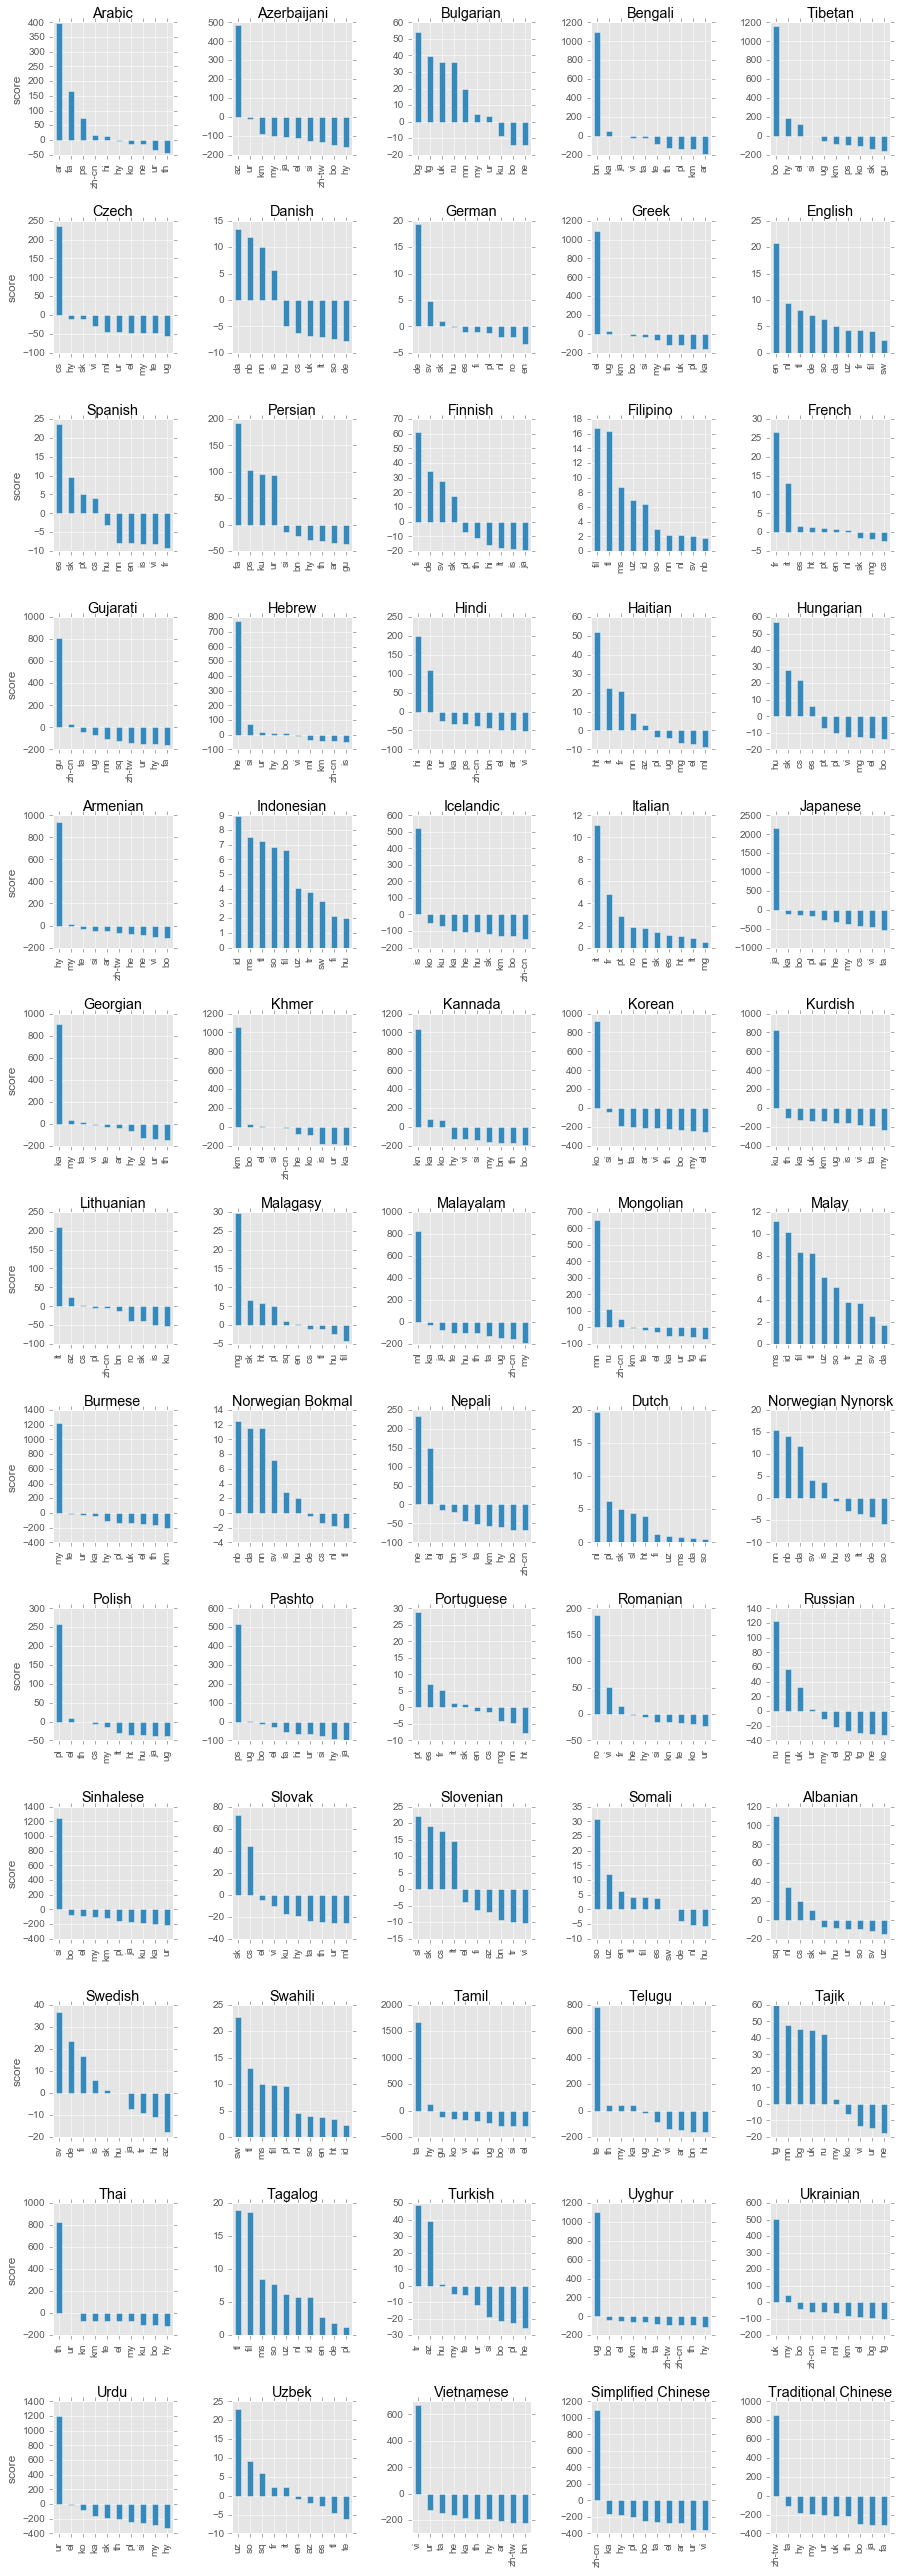

In [23]:
avg_scores_df = pd.DataFrame(avg_scores)

fig, axes = plt.subplots(13, 5, figsize=(15, 45))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for j, (ax, col) in enumerate(zip(axes.flatten(), avg_scores_df.columns)):
    top_k_df = avg_scores_df[[col]].sort_values(by=col, ascending=0).head(10)
    top_k_df['x'] = [classes[i] for i in top_k_df.index]

    ax = top_k_df.plot(x='x', kind='bar', ax=ax, title=class_names[col], color='#348abd', legend=False)
    if j % 5 == 0:
        ax.set_ylabel('score')
    ax.set_xlabel('')

#fig.savefig('score_distribution.svg')

Best 25

In [14]:
dic = {'precision': [float(tp[c]) / (tp[c] + fp[c]) for c in classes],
       'recall': [float(tp[c]) / (tp[c] + fn[c]) for c in classes],
       'avg_score': [avg_score[c] for c in classes]}
eval_df = pd.DataFrame(dic, index=classes)
eval_df['f1'] = 2 * (eval_df['precision'] * eval_df['recall']) / (eval_df['precision'] + eval_df['recall'])

def report(df, limit=25):
    print '{:>20} {:>12} {:>12} {:>12} {:>12}\n'.format('', 'avg. score', 'precision', 'recall', 'f1-score')
    for i, row in df.head(25).iterrows():
        string = '{:>20} {:>12.3f} {:>12.3f} {:>12.3f} {:>12.3f}'
        print string.format(class_names[i], row.avg_score, row.precision, row.recall, row.f1)
report(eval_df.sort_values(by=['f1', 'avg_score'], ascending=[False, False]))

                       avg. score    precision       recall     f1-score

               Tamil     1665.068        1.000        1.000        1.000
           Sinhalese     1242.681        1.000        1.000        1.000
             Burmese     1223.795        1.000        1.000        1.000
             Tibetan     1158.024        1.000        1.000        1.000
              Uyghur     1106.285        1.000        1.000        1.000
             Bengali     1101.598        1.000        1.000        1.000
               Greek     1088.558        1.000        1.000        1.000
               Khmer     1055.262        1.000        1.000        1.000
            Armenian      941.679        1.000        1.000        1.000
              Korean      919.747        1.000        1.000        1.000
            Georgian      903.265        1.000        1.000        1.000
           Malayalam      825.930        1.000        1.000        1.000
                Thai      824.824        1.000    

Worst 25

In [15]:
report(eval_df.sort_values(by=['f1', 'avg_score'], ascending=[True, True]))

                       avg. score    precision       recall     f1-score

          Indonesian        8.933        0.667        0.040        0.075
             Tagalog       19.005        0.400        0.080        0.133
    Norwegian Bokmal       12.547        0.381        0.640        0.478
              Danish       13.471        0.458        0.540        0.495
   Norwegian Nynorsk       15.516        0.733        0.440        0.550
               Malay       11.190        0.458        0.980        0.624
            Filipino       16.709        0.506        0.880        0.642
             Italian       11.146        0.548        0.920        0.687
              German       19.375        0.719        0.820        0.766
              Slovak       72.622        0.830        0.780        0.804
               Czech      236.366        0.848        0.780        0.812
             Swedish       36.640        0.902        0.740        0.813
          Portuguese       28.791        0.884    

In [16]:
sort = eval_df.sort_values(by=['f1', 'avg_score'], ascending=[False, False])
print '{:>6} {:>12} {:>12} {:>12} {:>12}\n'.format('', 'avg. score', 'precision', 'recall', 'f1-score')
for i in range(5, 65, 10):
    mean = sort.head(i).mean()
    string = 'top {:>2d} {:>12.3f} {:>12.3f} {:>12.3f} {:>12.3f}'
    print string.format(i, mean.avg_score, mean.precision, mean.recall, mean.f1)
mean = eval_df.mean()
string = '{:>6} {:>12.3f} {:>12.3f} {:>12.3f} {:>12.3f}'
print string.format('all', mean.avg_score, mean.precision, mean.recall, mean.f1)

         avg. score    precision       recall     f1-score

top  5     1279.171        1.000        1.000        1.000
top 15     1045.956        1.000        1.000        1.000
top 25      954.115        0.998        0.983        0.990
top 35      797.532        0.981        0.967        0.973
top 45      647.085        0.968        0.949        0.957
top 55      540.608        0.950        0.925        0.936
   all      460.522        0.891        0.877        0.873


Distribution of false-positives

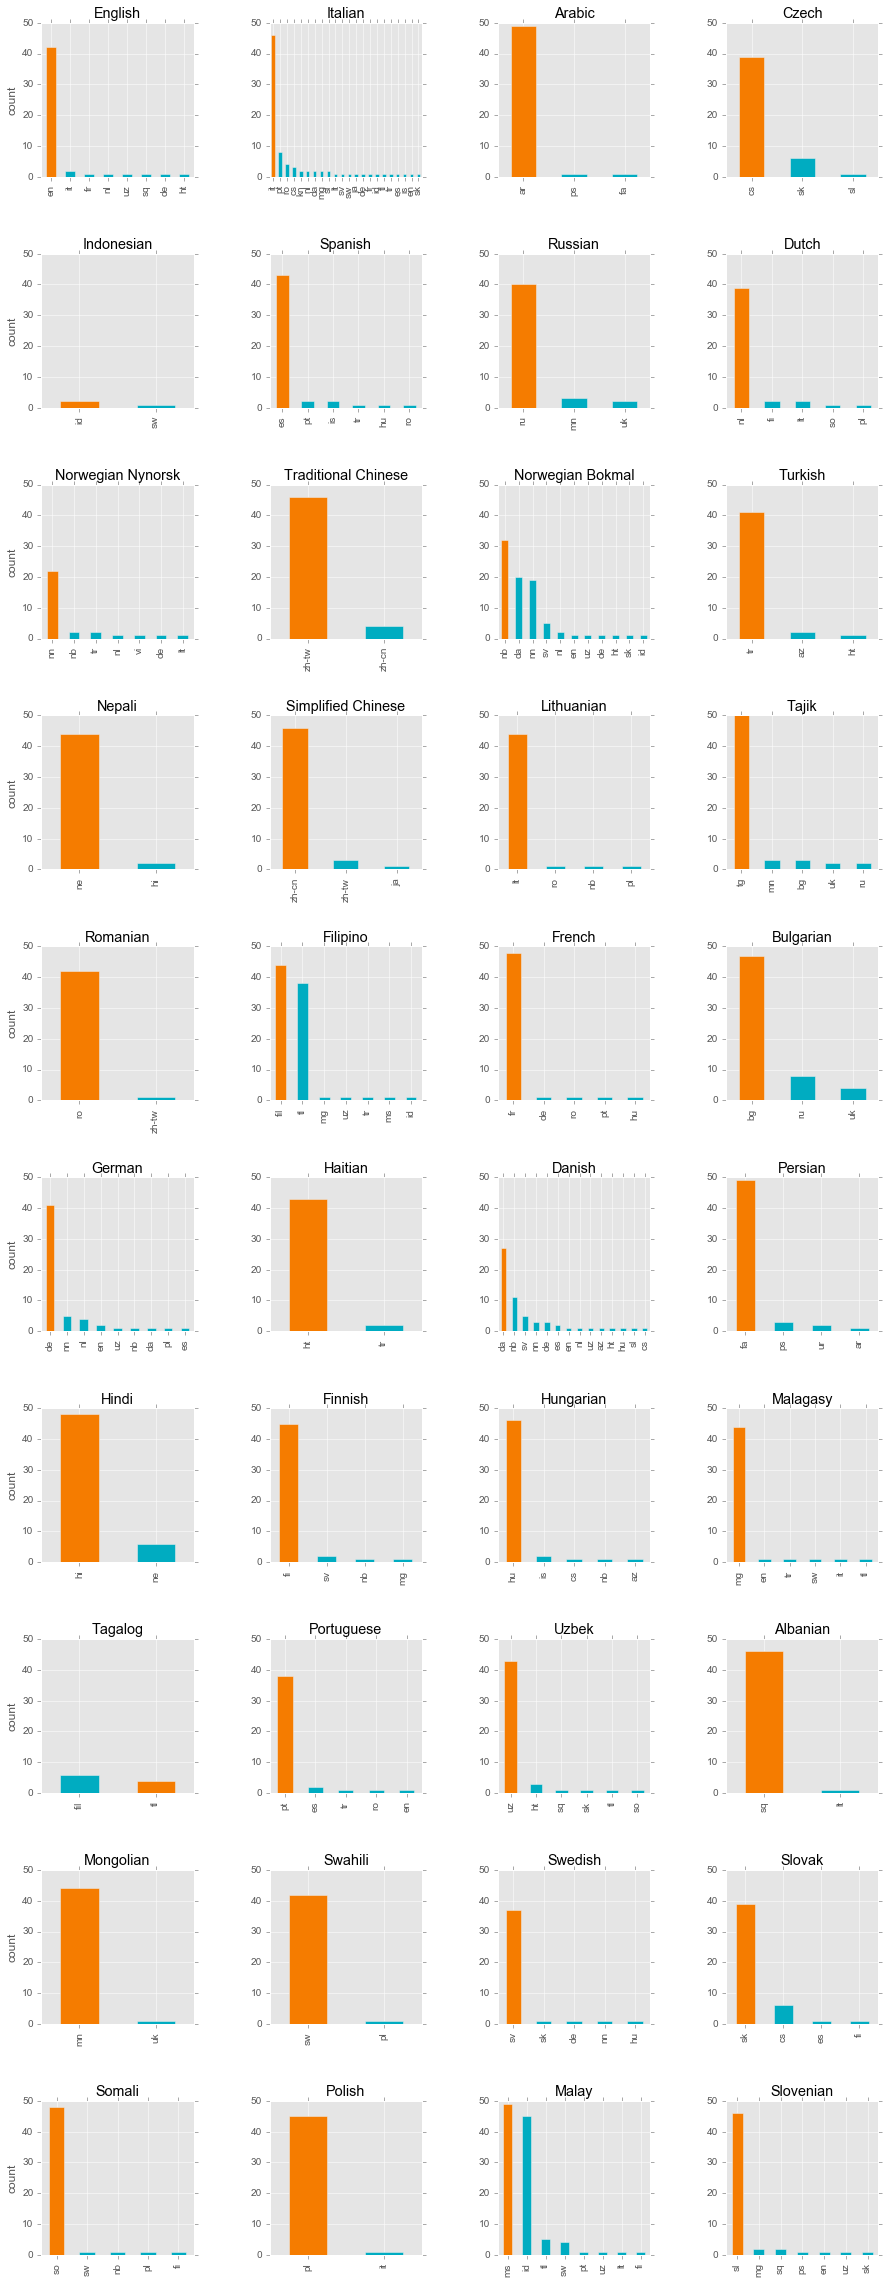

In [30]:
from collections import Counter

y_true = [classes[c] for c in scores_df.y_true]
y_pred = [classes[c] for c in scores_df.y_pred]

counter = {}
for code in classes:
    c = Counter([a for a, b in zip(y_true, y_pred) if b == code])
    if len(c) > 1:
        counter[code] = c
        #print class_names[code]
        #print c.most_common(50)
        #print

fig, axes = plt.subplots(10, 4, figsize=(15, 40))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for j, (ax, c) in enumerate(zip(axes.flatten(), counter.items())):
    fp_df = pd.DataFrame(c[1].most_common(50), columns=['x', 'y']).sort_values(by='y', ascending=0)
    colors = ['#00acc1'] * len(fp_df)
    idx = fp_df[fp_df.x == c[0]].index.values[0]
    if idx >= 0:
        colors[int(idx)] = '#f57c00'
    ax = fp_df.plot(x='x', kind='bar', color=colors, legend=False, ax=ax, title=class_names[c[0]])
    ax.set_label('TP')
    ax.set_ylim(0, 50)
    ax.set_xlabel('')  
    if j % 4 == 0:
        ax.set_ylabel('count')
        
#fig.savefig('fp_distribution.svg')

## Visualize train log

In [19]:
train_acc = pd.read_csv(os.path.join(FLAGS.train_dir, 'summaries', 'train-accuracy.csv'),
                        index_col=1, names=['time', 'train'], skiprows=[0])
dev_acc = pd.read_csv(os.path.join(FLAGS.train_dir, 'summaries', 'dev-accuracy.csv'), 
                      index_col=1, names=['time', 'dev'], skiprows=[0])
train_loss = pd.read_csv(os.path.join(FLAGS.train_dir, 'summaries', 'train-loss.csv'),
                        index_col=1, names=['time', 'train'], skiprows=[0])
dev_loss = pd.read_csv(os.path.join(FLAGS.train_dir, 'summaries', 'dev-loss.csv'), 
                      index_col=1, names=['time', 'dev'], skiprows=[0])

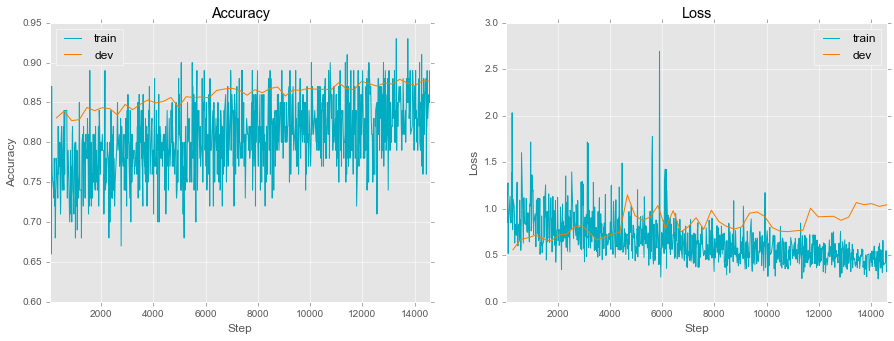

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = train_acc.train.plot(legend=True, color='#00acc1', ax=axes[0])
ax.set_xlabel('Step')
ax.set_ylabel('Accuracy')
ax = dev_acc.dev.plot(ax=ax, legend=True, color='#f57c00', title="Accuracy")

ax = train_loss.train.plot(legend=True, color='#00acc1', ax=axes[1])
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax = dev_loss.dev.plot(ax=ax, legend=True, color='#f57c00', title="Loss")

#fig.savefig('train_log.svg')

## TODO

What's next?
+ basline system with extracted features (instead of character embeddings)
+ parameter calibration
+ more examples for critical pairs (such as es-pr, ms-id, nn-nb) ???